In [2]:
# import pyspark.sql.functions as F
# from datetime import datetime, timedelta, date
# from pyspark.sql.types import TimestampType
# from pyspark.sql.functions import sum, to_date, col, when, month, dayofmonth, explode, array, struct, expr, lit , avg
import geopandas as gpd
# import matplotlib.pyplot as plt
from shapely import wkt, Point

import pandas as pd
import os

In [3]:
#load geojson polygon file
cells = gpd.read_file(f"../data/neerslag_ai/polygons_irc.geojson")
cells.index = cells["index"]
cells = cells.drop(columns=['index'])
cells

,geometry
index,
polygon_0,"POLYGON ((72370.233 420696.363, 73323.192 4206..."
polygon_1,"POLYGON ((73323.192 420610.729, 74276.142 4205..."
polygon_2,"POLYGON ((74276.142 420525.047, 75229.083 4204..."
polygon_3,"POLYGON ((75229.083 420439.316, 76182.016 4203..."
polygon_4,"POLYGON ((76182.016 420353.537, 77134.939 4202..."
...,...
polygon_3545,"POLYGON ((130906.100 368332.151, 131856.103 36..."
polygon_3546,"POLYGON ((131856.103 368243.772, 132806.098 36..."
polygon_3547,"POLYGON ((132806.098 368155.346, 133756.083 36..."


<Axes: >

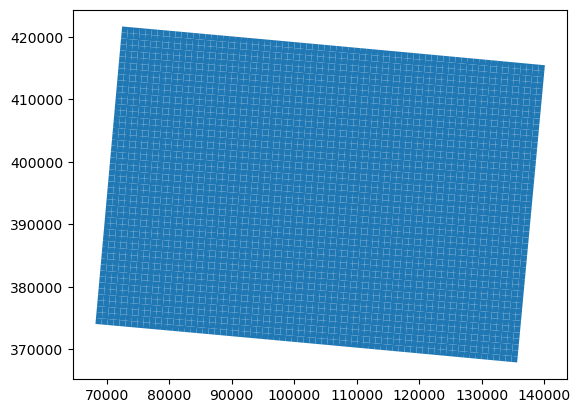

In [4]:
# Create a GeoDataFrame from the Pandas DataFrame
cells = gpd.GeoDataFrame(cells, geometry="geometry")

# Define the RD New and WGS84 CRS
crs_rd = "EPSG:28992"
crs_wgs84 = "EPSG:4326"

# Set the CRS of the original GeoDataFrame to RD New
cells.crs = crs_rd

# Convert the coordinates to WGS84 using .to_crs()
cells_84 = cells.to_crs(crs_wgs84)

# Plot the geometries using GeoPandas
cells.plot()

In [5]:
cells_84 = cells.to_crs(crs_wgs84)
cells_84

,geometry
index,
polygon_0,"POLYGON ((4.19008 51.76883, 4.20390 51.76820, ..."
polygon_1,"POLYGON ((4.20390 51.76820, 4.21773 51.76757, ..."
polygon_2,"POLYGON ((4.21773 51.76757, 4.23155 51.76694, ..."
polygon_3,"POLYGON ((4.23155 51.76694, 4.24537 51.76630, ..."
polygon_4,"POLYGON ((4.24537 51.76630, 4.25919 51.76566, ..."
...,...
polygon_3545,"POLYGON ((5.04170 51.30375, 5.05533 51.30299, ..."
polygon_3546,"POLYGON ((5.05533 51.30299, 5.06895 51.30223, ..."
polygon_3547,"POLYGON ((5.06895 51.30223, 5.08258 51.30148, ..."


In [10]:
point = Point(4.586668, 51.558512)

In [11]:
result = cells_84[cells_84['geometry'].contains(point)]
result

,geometry
index,
polygon_1663,"POLYGON ((4.57913 51.55202, 4.59286 51.55134, ..."


In [8]:
from concurrent.futures import ThreadPoolExecutor

def read_parquet(file_path, columns):
    return pd.read_parquet(file_path, columns=columns)

final_df_list = []
columns_to_read = ['timestamp', 'polygon_1475']  # Specify the columns you want to read

# Function to process each file
def process_file(file):
    if os.path.splitext(file)[1] == '.parquet':
        file_path = os.path.join(root, file)
        print(file_path)

        # Read only the specified columns
        df_weather = read_parquet(file_path, columns=columns_to_read)

        return df_weather

# Use ThreadPoolExecutor to parallelize file processing
with ThreadPoolExecutor() as executor:
    walker = os.walk("../data/neerslag_ai/")
    for root, dirs, files in walker:
        # Process each file concurrently
        result = list(executor.map(process_file, files))
        final_df_list.extend(result)

# Concatenate all DataFrames in the list
final_df = pd.concat(final_df_list, ignore_index=True)

../data/neerslag_ai/year=2023/month=1/day=1/part-00005-22b544ec-4fa4-4e2a-ac4f-3fd5d28123c4.c000.snappy.parquet../data/neerslag_ai/year=2023/month=1/day=1/part-00005-6ef38aa4-d531-4b04-bb2b-5e2185f5161f.c000.snappy.parquet

../data/neerslag_ai/year=2023/month=1/day=1/part-00005-9998e2fe-4b82-4f92-a7a6-535a87bd38d4.c000.snappy.parquet
../data/neerslag_ai/year=2023/month=1/day=1/part-00005-9ddcf8f7-f1d8-4538-9c16-d96288433639.c000.snappy.parquet
../data/neerslag_ai/year=2023/month=1/day=10/part-00009-09eb3e6b-826f-4b47-8daa-e428f9bc2779.c000.snappy.parquet
../data/neerslag_ai/year=2023/month=1/day=10/part-00009-5d322e44-1914-4b34-b85e-5a3798ff54da.c000.snappy.parquet
../data/neerslag_ai/year=2023/month=1/day=10/part-00009-7bb007a6-cd6c-4e11-932b-7b06ea370e7d.c000.snappy.parquet
../data/neerslag_ai/year=2023/month=1/day=10/part-00009-8489f3c3-9a9d-4bde-836e-2befe1f3c883.c000.snappy.parquet
../data/neerslag_ai/year=2023/month=1/day=11/part-00002-3a9239f4-54d0-473c-bd1b-46375360d535.c000.sn

In [9]:
final_df.to_parquet("polygon_1475.parquet")